# Chapter 6 of thesis, XGB + AENC

Comparison of classification metrics, feature importances

## Classification Metrics

In [1]:
import json
import os
import pickle

from glob import glob
from pprint import pprint

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# determine experiment paths

# engineered features + autoencoder embeddings
full_feat_embd = glob("cinc-2020-redux-embedding/*.json")
print(f"len(full_feat_embd) == {len(full_feat_embd)}")
top_1000_feat_embd = glob("cinc-2020-redux-embedding/top_1000/*.json")
print(f"len(top_1000_feat_embd) == {len(top_1000_feat_embd)}")
top_100_feat_embd = glob("cinc-2020-redux-embedding/top_100/*.json")
print(f"len(top_100_feat_embd) == {len(top_100_feat_embd)}")
avgd_top_1000_feat_embd = glob("cinc-2020-redux-embedding/averaged_top_1000/*.json")
print(f"len(avgd_top_1000_feat_embd) == {len(avgd_top_1000_feat_embd)}")
avgd_top_100_feat_embd = glob("cinc-2020-redux-embedding/averaged_top_100/*.json")
print(f"len(avgd_top_100_feat_embd) == {len(avgd_top_100_feat_embd)}")

# engineered features only
full_man_feat = glob("full_output/*.json")
print(f"len(full_man_feat) == {len(full_man_feat)}")
top_1000_man_feat = glob("full_output/top_1000/*.json")
print(f"len(top_1000_man_feat) == {len(top_1000_man_feat)}")
top_100_man_feat = glob("full_output/top_100/*.json")
print(f"len(top_100_man_feat) == {len(top_100_man_feat)}")
avgd_top_1000_man_feat = glob("full_output/averaged_top_1000/*.json")
print(f"len(avgd_top_1000_feat_embd) == {len(avgd_top_1000_man_feat)}")
avgd_top_100_man_feat = glob("full_output/averaged_top_100/*.json")
print(f"len(avgd_top_100_feat_embd) == {len(avgd_top_100_man_feat)}")

experiment_results = {
    "All Feats\nw/ Embd": full_feat_embd,
    "All Feats": full_man_feat,
    "Avg Top 1000\nFeats w/ Embd": avgd_top_1000_feat_embd,
    "Top 1000 Feats\nw/ Embd": top_1000_feat_embd,
    "Avg Top 100\nFeats w/ Embd": avgd_top_100_feat_embd,
    "Top 100 Feats\nw/ Embd": top_100_feat_embd,
    "Avg Top 1000 Feats": avgd_top_1000_man_feat,
    "Top 1000 Feats": top_1000_man_feat,
    "Avg Top 100 Feats": avgd_top_100_man_feat,
    "Top 100 Feats": top_100_man_feat,
}


len(full_feat_embd) == 20
len(top_1000_feat_embd) == 20
len(top_100_feat_embd) == 20
len(avgd_top_1000_feat_embd) == 20
len(avgd_top_100_feat_embd) == 20
len(full_man_feat) == 20
len(top_1000_man_feat) == 20
len(top_100_man_feat) == 20
len(avgd_top_1000_feat_embd) == 20
len(avgd_top_100_feat_embd) == 20


In [3]:
# Create a pandas dataframe of all challenge metrics
df_dict = {
    "Experiment": [],
    "Metric": [],
    "Value": []
}

for experiment, fps in experiment_results.items():
    for file_path in fps:
        with open(file_path, "r") as f:
            results = json.load(f)
        df_dict["Metric"].append("AUROC")
        df_dict["Value"].append(results["test_auroc"])
        df_dict["Experiment"].append(experiment)
        df_dict["Metric"].append("AUPRC")
        df_dict["Value"].append(results["test_auprc"])
        df_dict["Experiment"].append(experiment)
        df_dict["Metric"].append("Accuracy")
        df_dict["Value"].append(results["test_accuracy"])
        df_dict["Experiment"].append(experiment)
        df_dict["Metric"].append("F Measure")
        df_dict["Value"].append(results["test_f_measure"])
        df_dict["Experiment"].append(experiment)
        df_dict["Metric"].append("F-Beta\nMeasure")
        df_dict["Value"].append(results["test_f_beta_measure"])
        df_dict["Experiment"].append(experiment)
        df_dict["Metric"].append("G-Beta\nMeasure")
        df_dict["Value"].append(results["test_g_beta_measure"])
        df_dict["Experiment"].append(experiment)
        df_dict["Metric"].append("Challenge\nMetric")
        df_dict["Value"].append(results["test_challenge_metric"])
        df_dict["Experiment"].append(experiment)

challenge_results_df = pd.DataFrame.from_dict(df_dict)
challenge_results_df

,Experiment,Metric,Value
0,All Feats\nw/ Embd,AUROC,0.870934
1,All Feats\nw/ Embd,AUPRC,0.377845
2,All Feats\nw/ Embd,Accuracy,0.318720
3,All Feats\nw/ Embd,F Measure,0.355513
4,All Feats\nw/ Embd,F-Beta\nMeasure,0.397154
...,...,...,...
1395,Top 100 Feats,Accuracy,0.295523
1396,Top 100 Feats,F Measure,0.360957
1397,Top 100 Feats,F-Beta\nMeasure,0.415745
1398,Top 100 Feats,G-Beta\nMeasure,0.215022


In [4]:
# Mean and standard deviations of all experiments/metrics
group = challenge_results_df.groupby(["Experiment", "Metric"], group_keys=False)
tbl_grp = group.agg({"Value": ["mean", "std"]})

# with pd.option_context("display.max_rows", None):
display(tbl_grp)

group_dict = dict(tbl_grp)
print(group_dict.keys())
group_dict[("Value", "mean")] = dict(group_dict[("Value", "mean")])
exp_means = {}
for k in experiment_results.keys():
    exp_means[k] = [""] * 7
for (exp_name, metric), mean in group_dict[("Value", "mean")].items():
    if metric == "AUROC":
        exp_means[exp_name][0] = mean
    elif metric == "AUPRC":
        exp_means[exp_name][1] = mean
    elif metric == "Accuracy":
        exp_means[exp_name][2] = mean
    elif metric == "F Measure":
        exp_means[exp_name][3] = mean
    elif metric == "F-Beta\nMeasure":
        exp_means[exp_name][4] = mean
    elif metric == "G-Beta\nMeasure":
        exp_means[exp_name][5] = mean
    elif metric == "Challenge\nMetric":
        exp_means[exp_name][6] = mean

for k, v in exp_means.items():
    print(k, max(v))
    tex_v = [f"${val:.4f}$" for val in v]
    print(" & ".join(tex_v))

exp_mat_means = np.array([np.array(val) for val in exp_means.values()])
display(exp_mat_means.argmax(axis=0))

print()
group_dict[("Value", "std")] = dict(group_dict[("Value", "std")])
exp_stds = {}
for k in experiment_results.keys():
    exp_stds[k] = [""] * 7
for (exp_name, metric), std in group_dict[("Value", "std")].items():
    if metric == "AUROC":
        exp_stds[exp_name][0] = std
    elif metric == "AUPRC":
        exp_stds[exp_name][1] = std
    elif metric == "Accuracy":
        exp_stds[exp_name][2] = std
    elif metric == "F Measure":
        exp_stds[exp_name][3] = std
    elif metric == "F-Beta\nMeasure":
        exp_stds[exp_name][4] = std
    elif metric == "G-Beta\nMeasure":
        exp_stds[exp_name][5] = std
    elif metric == "Challenge\nMetric":
        exp_stds[exp_name][6] = std

for k, v in exp_stds.items():
    print(k)
    tex_v = [f"{val:.1E}" for val in v]
    tex_v = ["$" + " \\times 10^{".join(val.split("E")) + "}$" for val in tex_v]
    print(" & ".join(tex_v))


Value          
                                               mean       std
Experiment              Metric                               
All Feats               AUPRC              0.380887  0.005007
                        AUROC              0.881471  0.005470
                        Accuracy           0.313871  0.007903
                        Challenge\nMetric  0.420622  0.010026
                        F Measure          0.358178  0.006000
...                                             ...       ...
Top 1000 Feats\nw/ Embd Accuracy           0.306217  0.005425
                        Challenge\nMetric  0.431565  0.007008
                        F Measure          0.361318  0.005437
                        F-Beta\nMeasure    0.412790  0.006656
                        G-Beta\nMeasure    0.218284  0.004286

[70 rows x 2 columns]

dict_keys([('Value', 'mean'), ('Value', 'std')])
All Feats
w/ Embd 0.8821367780555983
$0.8821$ & $0.3813$ & $0.3137$ & $0.3587$ & $0.4047$ & $0.2160$ & $0.4207$
All Feats 0.8814714279661876
$0.8815$ & $0.3809$ & $0.3139$ & $0.3582$ & $0.4036$ & $0.2150$ & $0.4206$
Avg Top 1000
Feats w/ Embd 0.8875720555707651
$0.8876$ & $0.3900$ & $0.3068$ & $0.3637$ & $0.4165$ & $0.2194$ & $0.4366$
Top 1000 Feats
w/ Embd 0.8836017596060222
$0.8836$ & $0.3837$ & $0.3062$ & $0.3613$ & $0.4128$ & $0.2183$ & $0.4316$
Avg Top 100
Feats w/ Embd 0.8739521216024713
$0.8740$ & $0.3740$ & $0.2800$ & $0.3482$ & $0.4062$ & $0.2066$ & $0.4215$
Top 100 Feats
w/ Embd 0.8835766415949416
$0.8836$ & $0.3876$ & $0.2820$ & $0.3588$ & $0.4190$ & $0.2143$ & $0.4348$
Avg Top 1000 Feats 0.8870940058920548
$0.8871$ & $0.3890$ & $0.3085$ & $0.3640$ & $0.4165$ & $0.2187$ & $0.4358$
Top 1000 Feats 0.8843017393152923
$0.8843$ & $0.3836$ & $0.3075$ & $0.3619$ & $0.4126$ & $0.2179$ & $0.4295$
Avg Top 100 Feats 0.8714049111266734
$0

array([2, 2, 1, 6, 9, 2, 2])


All Feats
w/ Embd
$5.3 \times 10^{-03}$ & $4.9 \times 10^{-03}$ & $6.8 \times 10^{-03}$ & $5.9 \times 10^{-03}$ & $8.1 \times 10^{-03}$ & $3.9 \times 10^{-03}$ & $7.7 \times 10^{-03}$
All Feats
$5.5 \times 10^{-03}$ & $5.0 \times 10^{-03}$ & $7.9 \times 10^{-03}$ & $6.0 \times 10^{-03}$ & $8.6 \times 10^{-03}$ & $5.2 \times 10^{-03}$ & $1.0 \times 10^{-02}$
Avg Top 1000
Feats w/ Embd
$4.6 \times 10^{-03}$ & $5.5 \times 10^{-03}$ & $6.5 \times 10^{-03}$ & $4.5 \times 10^{-03}$ & $6.0 \times 10^{-03}$ & $4.3 \times 10^{-03}$ & $7.1 \times 10^{-03}$
Top 1000 Feats
w/ Embd
$4.8 \times 10^{-03}$ & $6.4 \times 10^{-03}$ & $5.4 \times 10^{-03}$ & $5.4 \times 10^{-03}$ & $6.7 \times 10^{-03}$ & $4.3 \times 10^{-03}$ & $7.0 \times 10^{-03}$
Avg Top 100
Feats w/ Embd
$5.1 \times 10^{-03}$ & $7.8 \times 10^{-03}$ & $9.7 \times 10^{-03}$ & $6.5 \times 10^{-03}$ & $6.8 \times 10^{-03}$ & $5.2 \times 10^{-03}$ & $9.9 \times 10^{-03}$
Top 100 Feats
w/ Embd
$4.9 \times 10^{-03}$ & $7.0 \times 10^{-03

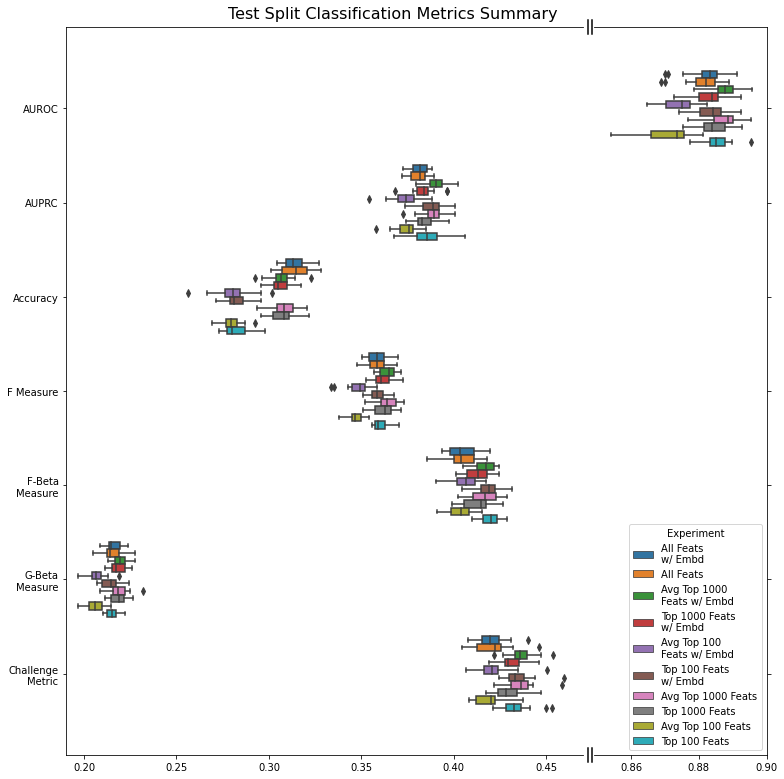

In [5]:
fig, (ax, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
    figsize=(11, 11),
    gridspec_kw={"width_ratios": [3, 1]}
)

# without AUROC
ax = sns.boxplot(
    data=challenge_results_df,
    x="Value",
    y="Metric",
    hue="Experiment",
    ax=ax
)
ax2 = sns.boxplot(
    data=challenge_results_df,
    x="Value",
    y="Metric",
    hue="Experiment",
    ax=ax2
)

# zoom/limit the view to portions of the data
ax.set_xlim(0.19, 0.47)
ax2.set_xlim(0.849, 0.9)

# hide the spines between ax and ax2
ax.spines["right"].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
ax2.spines["left"].set_visible(False)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.yaxis.tick_right()

ax.get_legend().remove()
ax2.legend(title="Experiment", loc="lower right")

# In axes coordinates, which are always between 0-1, spine endpoints
# are at these locations (0,0), (0,1), (1,0), and (1,1).

# draw cutout diagonal lines on the axis coordinates
d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 + d, 1 + d), (1 + d, 1 - d), **kwargs)  # top-left | 
ax.plot((1 + d, 1 + d), (+ d, - d), **kwargs)  # bottom-left |

d = .01  # how big to make the diagonal lines in axes coordinates
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, -d), (-d, +d), **kwargs)  # bottom-right diagonal
ax2.plot((-d, -d), (1 - d, 1 + d), **kwargs)  # top-right diagonal

fig.suptitle("Test Split Classification Metrics Summary", fontsize=16)

plt.subplots_adjust(wspace=0.05, top=0.92, bottom=0.05)
plt.tight_layout()
plt.savefig("fig/xgb_aenc_classification_metrics.pdf", bbox_inches="tight", dpi=300)
plt.show()


In [6]:
experiment_results.keys()

dict_keys(['All Feats\nw/ Embd', 'All Feats', 'Avg Top 1000\nFeats w/ Embd', 'Top 1000 Feats\nw/ Embd', 'Avg Top 100\nFeats w/ Embd', 'Top 100 Feats\nw/ Embd', 'Avg Top 1000 Feats', 'Top 1000 Feats', 'Avg Top 100 Feats', 'Top 100 Feats'])

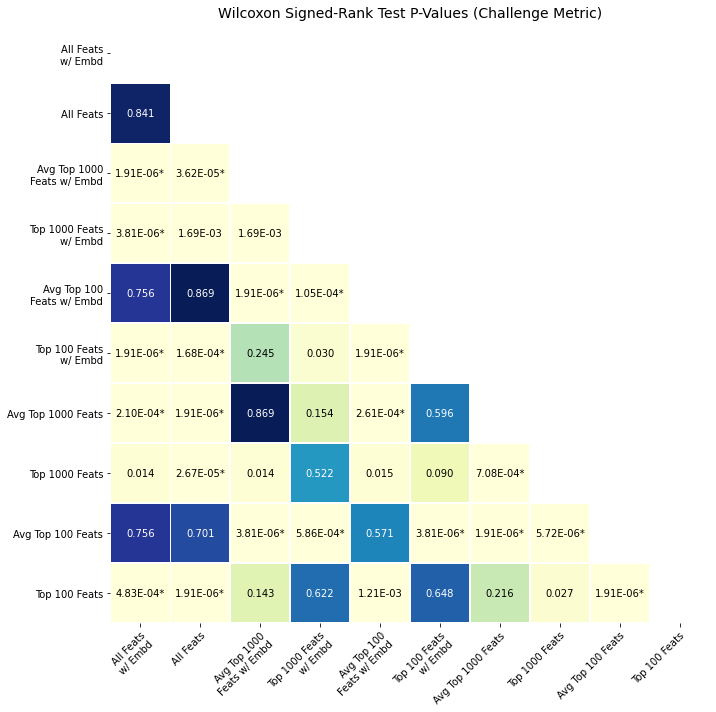

In [7]:
# Are the challenge metrics statistically
# different compared to the other approaches?

challenge_metrics = challenge_results_df.groupby(
    ["Experiment", "Metric"]).agg({"Value": list})

cmp = np.zeros((len(experiment_results.keys()), len(experiment_results.keys())))
exp_keys = [
    'All Feats\nw/ Embd',
    'All Feats',
    'Avg Top 1000\nFeats w/ Embd',
    'Top 1000 Feats\nw/ Embd',
    'Avg Top 100\nFeats w/ Embd',
    'Top 100 Feats\nw/ Embd',
    'Avg Top 1000 Feats',
    'Top 1000 Feats',
    'Avg Top 100 Feats',
    'Top 100 Feats',
]

for (i1, k1) in enumerate(exp_keys):
    for (i2, k2) in enumerate(exp_keys):
        if k1 == k2:
            continue
        x = challenge_metrics.loc[k1, "Challenge\nMetric"].to_numpy()[0]
        y = challenge_metrics.loc[k2, "Challenge\nMetric"].to_numpy()[0]
        # print(x, y)
        stat_output = sp.stats.wilcoxon(x=x, y=y,)
        #print(repr(k1), repr(k2))
        #print(stat_output)
        #print()
        cmp[i1][i2] = stat_output[1]
# print(cmp)

mask = np.zeros_like(cmp)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(
        cmp,
        annot=False,
        mask=mask,
        square=True,
        xticklabels=exp_keys,
        yticklabels=exp_keys,
        linewidths=.5,
        cmap="YlGnBu",
        cbar=False,
        ax=ax
    )
ax.set_title("Wilcoxon Signed-Rank Test P-Values (Challenge Metric)", fontsize=14)

for i in range(len(exp_keys)):
    for j in range(i+1, len(exp_keys)):
        p_val = cmp[i, j]
        if p_val > 0.3:
            color = "white"
        else:
            color = "black"
        
        p_str = f"{p_val:.3f}"
        if p_val < 0.009:
            p_str = f"{p_val:.2E}"
        if p_val < 0.001:
            p_str += "*"
        ax.text(i+.5, j+.5, p_str, ha="center", va="center", color=color)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

plt.tight_layout()
plt.savefig("fig/xgb_aenc_wilcoxon_srt_p_vals.pdf", dpi=300)
plt.show()

## Feature Importances


In [8]:
with open("data/snomed_ct_dx_map.json", "r") as f:
    SNOMED_CODE_MAP = json.load(f)


In [9]:
# Determine model paths

# engineered features + autoencoder embeddings
full_feat_embd = glob("cinc-2020-redux-embedding/*.pkl")
print(f"len(full_feat_embd) == {len(full_feat_embd)}")
top_1000_feat_embd = glob("cinc-2020-redux-embedding/top_1000/*.pkl")
print(f"len(top_1000_feat_embd) == {len(top_1000_feat_embd)}")
top_100_feat_embd = glob("cinc-2020-redux-embedding/top_100/*.pkl")
print(f"len(top_100_feat_embd) == {len(top_100_feat_embd)}")

# engineered features only
full_man_feat = glob("full_output/*.pkl")
print(f"len(full_man_feat) == {len(full_man_feat)}")
top_1000_man_feat = glob("full_output/top_1000/*.pkl")
print(f"len(top_1000_man_feat) == {len(top_1000_man_feat)}")
top_100_man_feat = glob("full_output/top_100/*.pkl")
print(f"len(top_100_man_feat) == {len(top_100_man_feat)}")

experiment_results = {
    "All Feats w/ Embd": full_feat_embd,
    "All Feats": full_man_feat,
}


len(full_feat_embd) == 20
len(top_1000_feat_embd) == 20
len(top_100_feat_embd) == 20
len(full_man_feat) == 20
len(top_1000_man_feat) == 20
len(top_100_man_feat) == 20


In [10]:
# Create a pandas dataframe of all challenge metrics
imp_dict = {}

for experiment, fps in experiment_results.items():
    experiments = []
    for file_path in fps:
        with open(file_path, "rb") as f:
            results = pickle.load(f)
        print(file_path)
        code_imps = {}
        for code, model in results.items():
            if code == "data_config":
                continue
            code_imps[code] = model.feature_importances_
        experiments.append(code_imps)
    imp_dict[experiment] = experiments

cinc-2020-redux-embedding/version_13_models.pkl
cinc-2020-redux-embedding/version_5_models.pkl
cinc-2020-redux-embedding/version_0_models.pkl
cinc-2020-redux-embedding/version_8_models.pkl
cinc-2020-redux-embedding/version_15_models.pkl
cinc-2020-redux-embedding/version_10_models.pkl
cinc-2020-redux-embedding/version_2_models.pkl
cinc-2020-redux-embedding/version_16_models.pkl
cinc-2020-redux-embedding/version_17_models.pkl
cinc-2020-redux-embedding/version_11_models.pkl
cinc-2020-redux-embedding/version_12_models.pkl
cinc-2020-redux-embedding/version_4_models.pkl
cinc-2020-redux-embedding/version_14_models.pkl
cinc-2020-redux-embedding/version_6_models.pkl
cinc-2020-redux-embedding/version_3_models.pkl
cinc-2020-redux-embedding/version_19_models.pkl
cinc-2020-redux-embedding/version_18_models.pkl
cinc-2020-redux-embedding/version_7_models.pkl
cinc-2020-redux-embedding/version_1_models.pkl
cinc-2020-redux-embedding/version_9_models.pkl
full_output/v17_models.pkl
full_output/v9_models.p

In [11]:

# 53 HRV features, 763 Heart Beat, 763 Embedding features per lead 
# All Feats w/ Embd (19718 features)
# 0 age
# 1 sex

with open("feature_cols.json", "r") as f:
    head = json.load(f)
print(f"{len(head)} feature columns")
embd_str = [f"seq_embed_{i}" for i in range(0, 768)]
head += embd_str

head = np.array(head[1:])

# top 1000 distribution
top_1000_imp_feats_per_code = {}
for experiment in imp_dict["All Feats w/ Embd"]:
    for code, importances in experiment.items():
        sorted_feat_idxs = importances.argsort()
        imp_idxs = top_1000_imp_feats_per_code.get(code, [])
        imp_idxs.append(head[list(sorted_feat_idxs[::-1][:1000])])
        top_1000_imp_feats_per_code[code] = imp_idxs


imp_feature_dict = {
    "Label": [],      # diagnosis label abbreviation
    "Experiment": [], # experiment number
    "Lead": [], # I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6, Other (sex/age)
    "Type": [], # HRV, Heartbeat, Signal, Sex, Age
}

for code, important_features_lists in top_1000_imp_feats_per_code.items():
    label = SNOMED_CODE_MAP[code][0]
    for experiment_idx, important_features in enumerate(important_features_lists):
        for important_feature in important_features:
            # determine lead
            try:
                lead = important_feature.split("_")[0]
                if lead == "seq":
                    lead = "AENC"
                elif lead == "age" or lead == "sex":
                    lead = "Meta"
            except:
                lead = "Other"
            
            # determine feature type
            if important_feature.startswith(f"{lead}_HRV") or important_feature.startswith(f"{lead}_ECG_Rate_Mean"):
                feat_type = "Heart Rate"
            elif important_feature.startswith(f"{lead}_hb__"):
                feat_type = "Heartbeat"
            elif important_feature.startswith(f"{lead}_sig__"):
                feat_type = "Full Signal"
            elif important_feature.startswith("seq_embed_"):
                feat_type = "Embedding"
            elif important_feature == "age":
                feat_type = "Age"
            elif important_feature == "sex":
                feat_type = "Sex"
            else:
                raise Exception(important_feature)
            
            imp_feature_dict["Label"].append(label)
            imp_feature_dict["Experiment"].append(experiment_idx)
            imp_feature_dict["Lead"].append(lead)
            imp_feature_dict["Type"].append(feat_type)

imp_feature_df = pd.DataFrame.from_dict(imp_feature_dict)

# with pd.option_context("display.max_rows", None):
display(imp_feature_df)
# display(imp_feature_df.groupby(["Label", "Lead", "Experiment"]).count())
display(imp_feature_df.groupby(["Label", "Lead", "Type"]).count())


18951 feature columns


,Label,Experiment,Lead,Type
0,IAVB,0,aVR,Heart Rate
1,IAVB,0,I,Full Signal
2,IAVB,0,aVR,Full Signal
3,IAVB,0,V6,Heart Rate
4,IAVB,0,aVR,Full Signal
...,...,...,...,...
539995,VPB,19,AENC,Embedding
539996,VPB,19,AENC,Embedding
539997,VPB,19,aVF,Heartbeat
539998,VPB,19,V5,Heartbeat


Experiment
Label Lead Type                   
AF    AENC Embedding           711
      I    Full Signal         654
           Heart Rate          173
           Heartbeat           798
      II   Full Signal         736
...                            ...
VPB   aVL  Heart Rate          150
           Heartbeat           549
      aVR  Full Signal         679
           Heart Rate          128
           Heartbeat           739

[1045 rows x 1 columns]

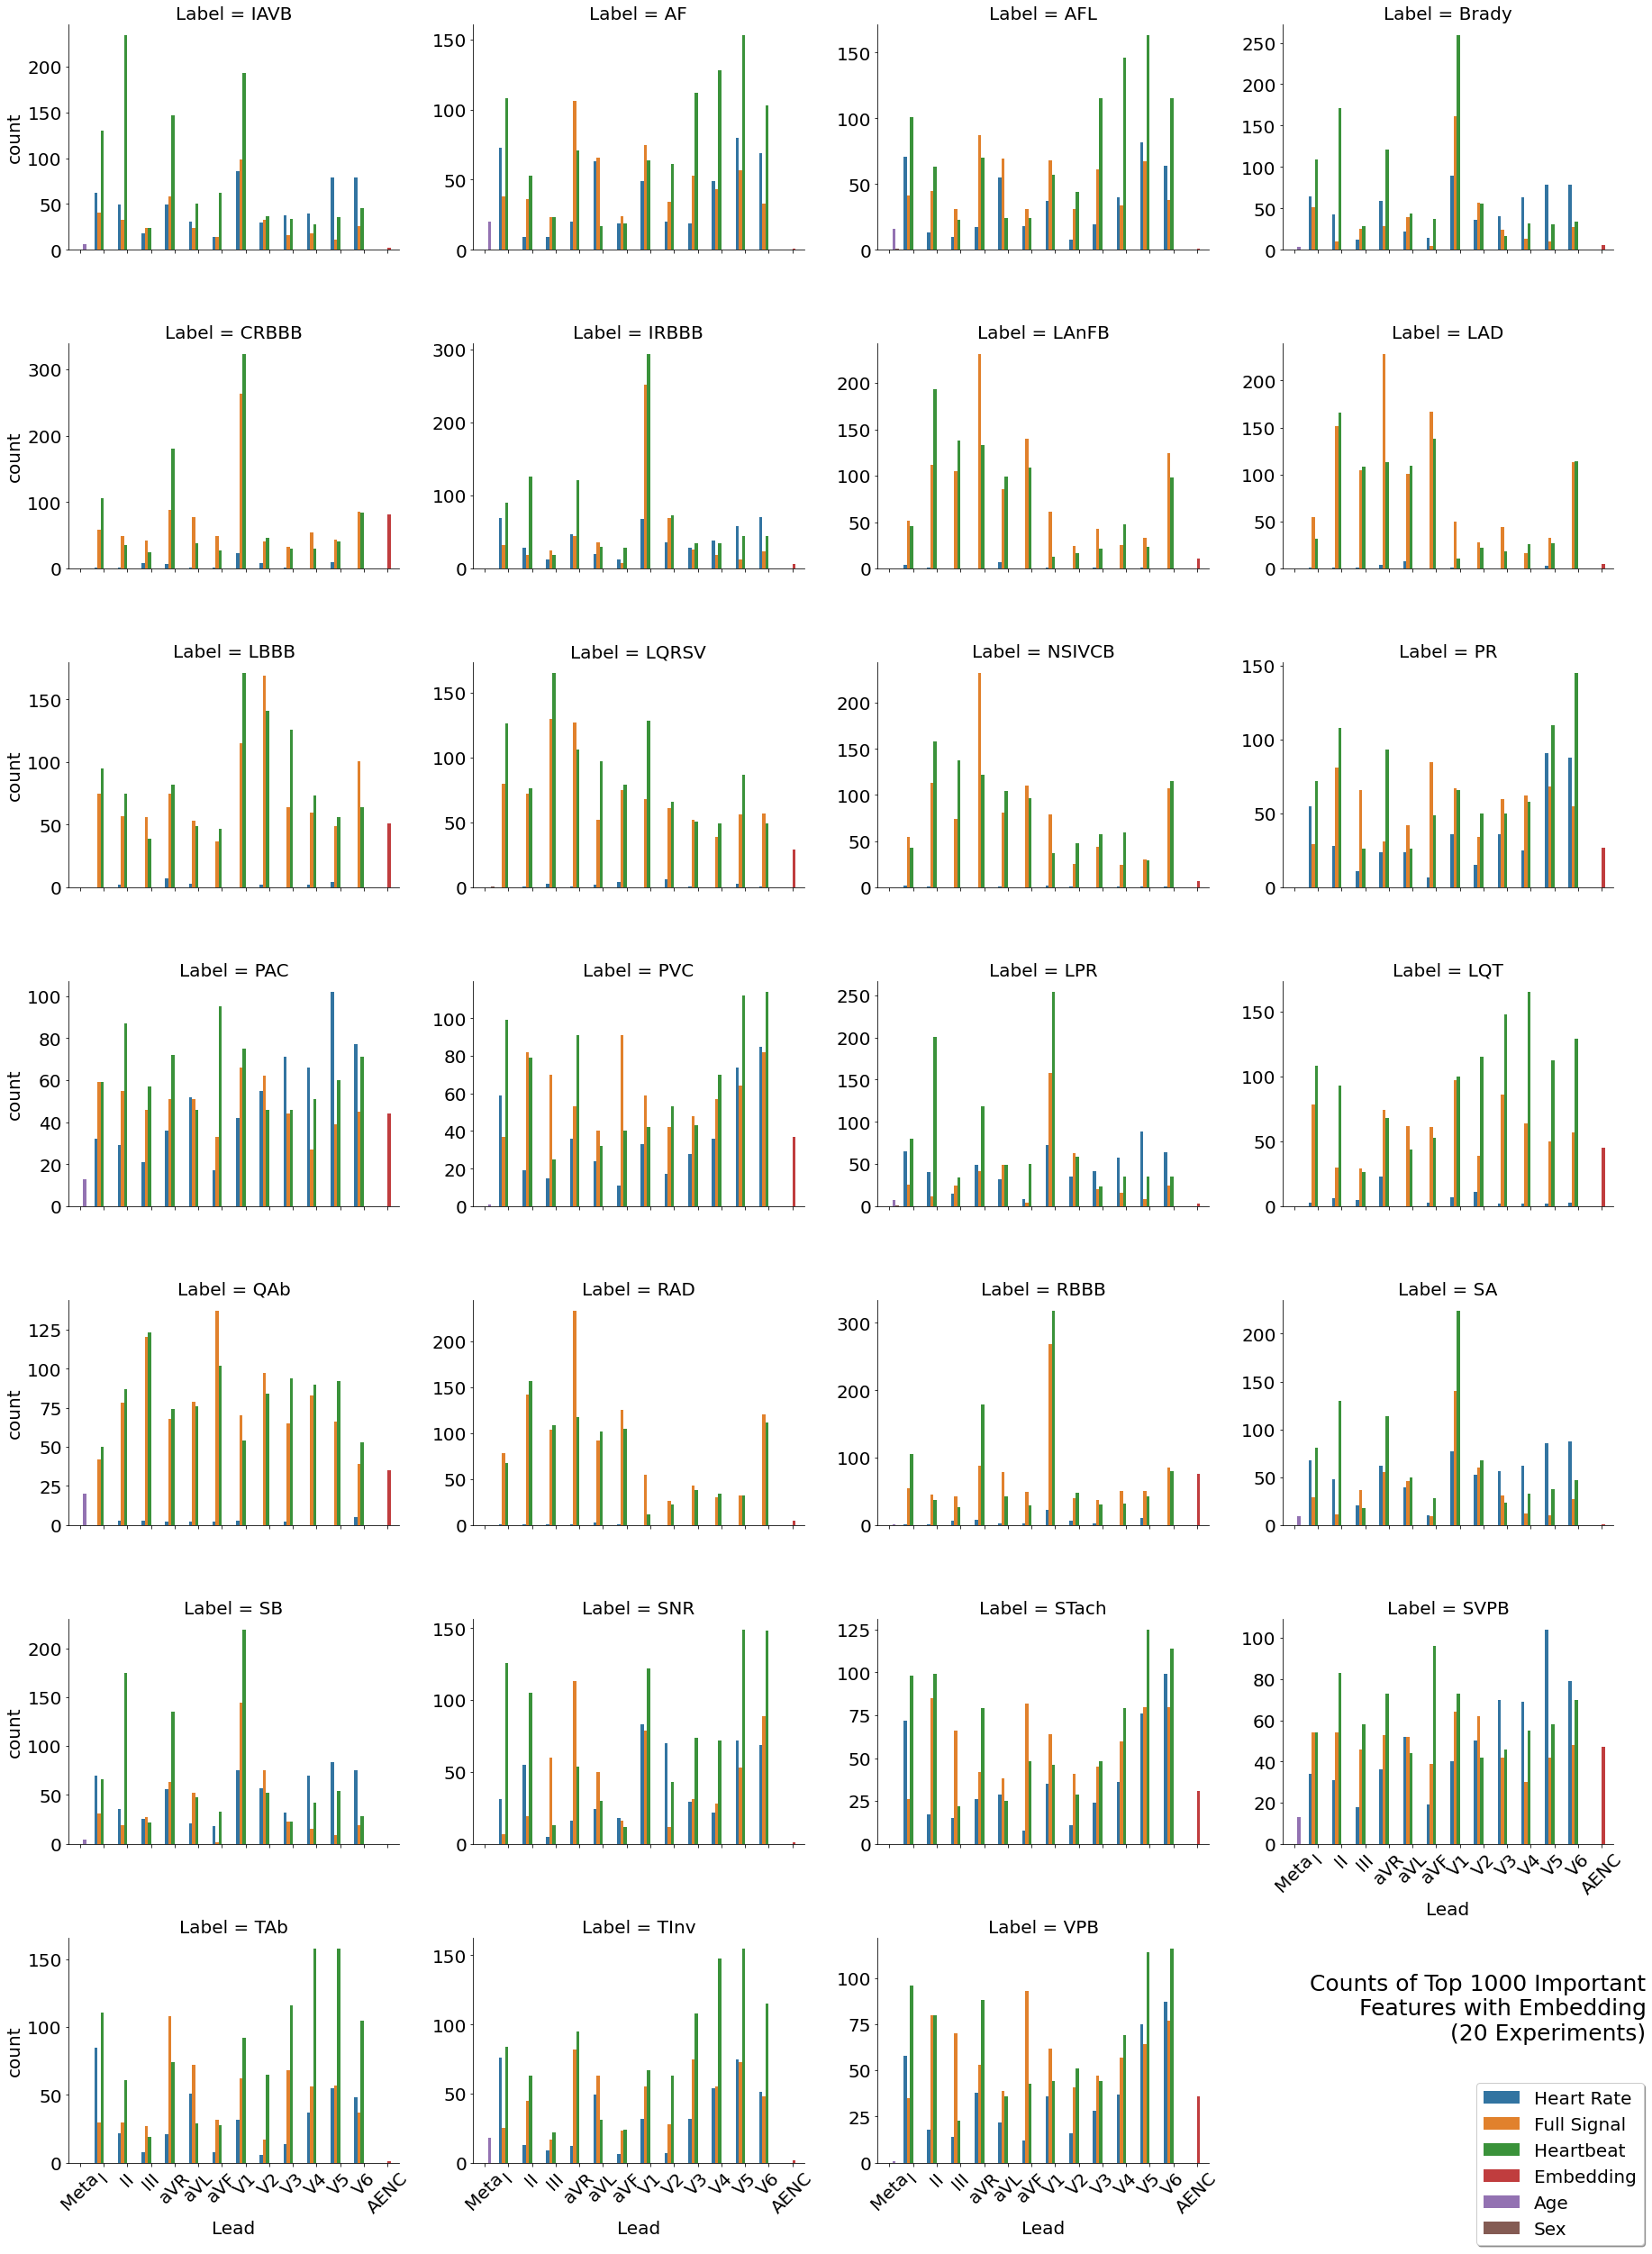

In [24]:
plt.rcParams["font.size"] = "20"
ax = sns.catplot(
    data=imp_feature_df,
    x="Lead",
    hue="Type",
    col="Label",
    kind="count",
    hue_order=["Heart Rate", "Full Signal", "Heartbeat", "Embedding", "Age", "Sex"],
    order=["Meta", "I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6", "AENC"],
    sharey=False,
    legend=False,
    legend_out=True,
    aspect=1.15,
    col_wrap=4,
)
ax.set_xticklabels(rotation=45)
ax.add_legend(frameon=True, shadow=True, loc="lower right", prop={"size": 20})
plt.tight_layout()
# ax.axes[0].legend(loc="lower right")
ax.fig.suptitle('Counts of Top 1000 Important\nFeatures with Embedding\n(20 Experiments)', x=1, y=0.125, ha="right", fontsize=25)
plt.savefig("fig/top_1000_feature_importances_all_w_embedding.pdf", dpi=300)
plt.show()

,Label,Lead,Type,Utilization
0,IAVB,aVR,Heart Rate,0.037736
1,IAVB,I,Full Signal,0.003932
2,IAVB,aVR,Full Signal,0.006553
3,IAVB,V6,Heart Rate,0.056604
4,IAVB,V5,Heart Rate,0.075472
...,...,...,...,...
15804,VPB,aVF,Heart Rate,0.037736
15805,VPB,aVL,Heartbeat,0.001311
15806,VPB,V4,Heartbeat,0.001311
15807,VPB,V1,Heartbeat,0.002621


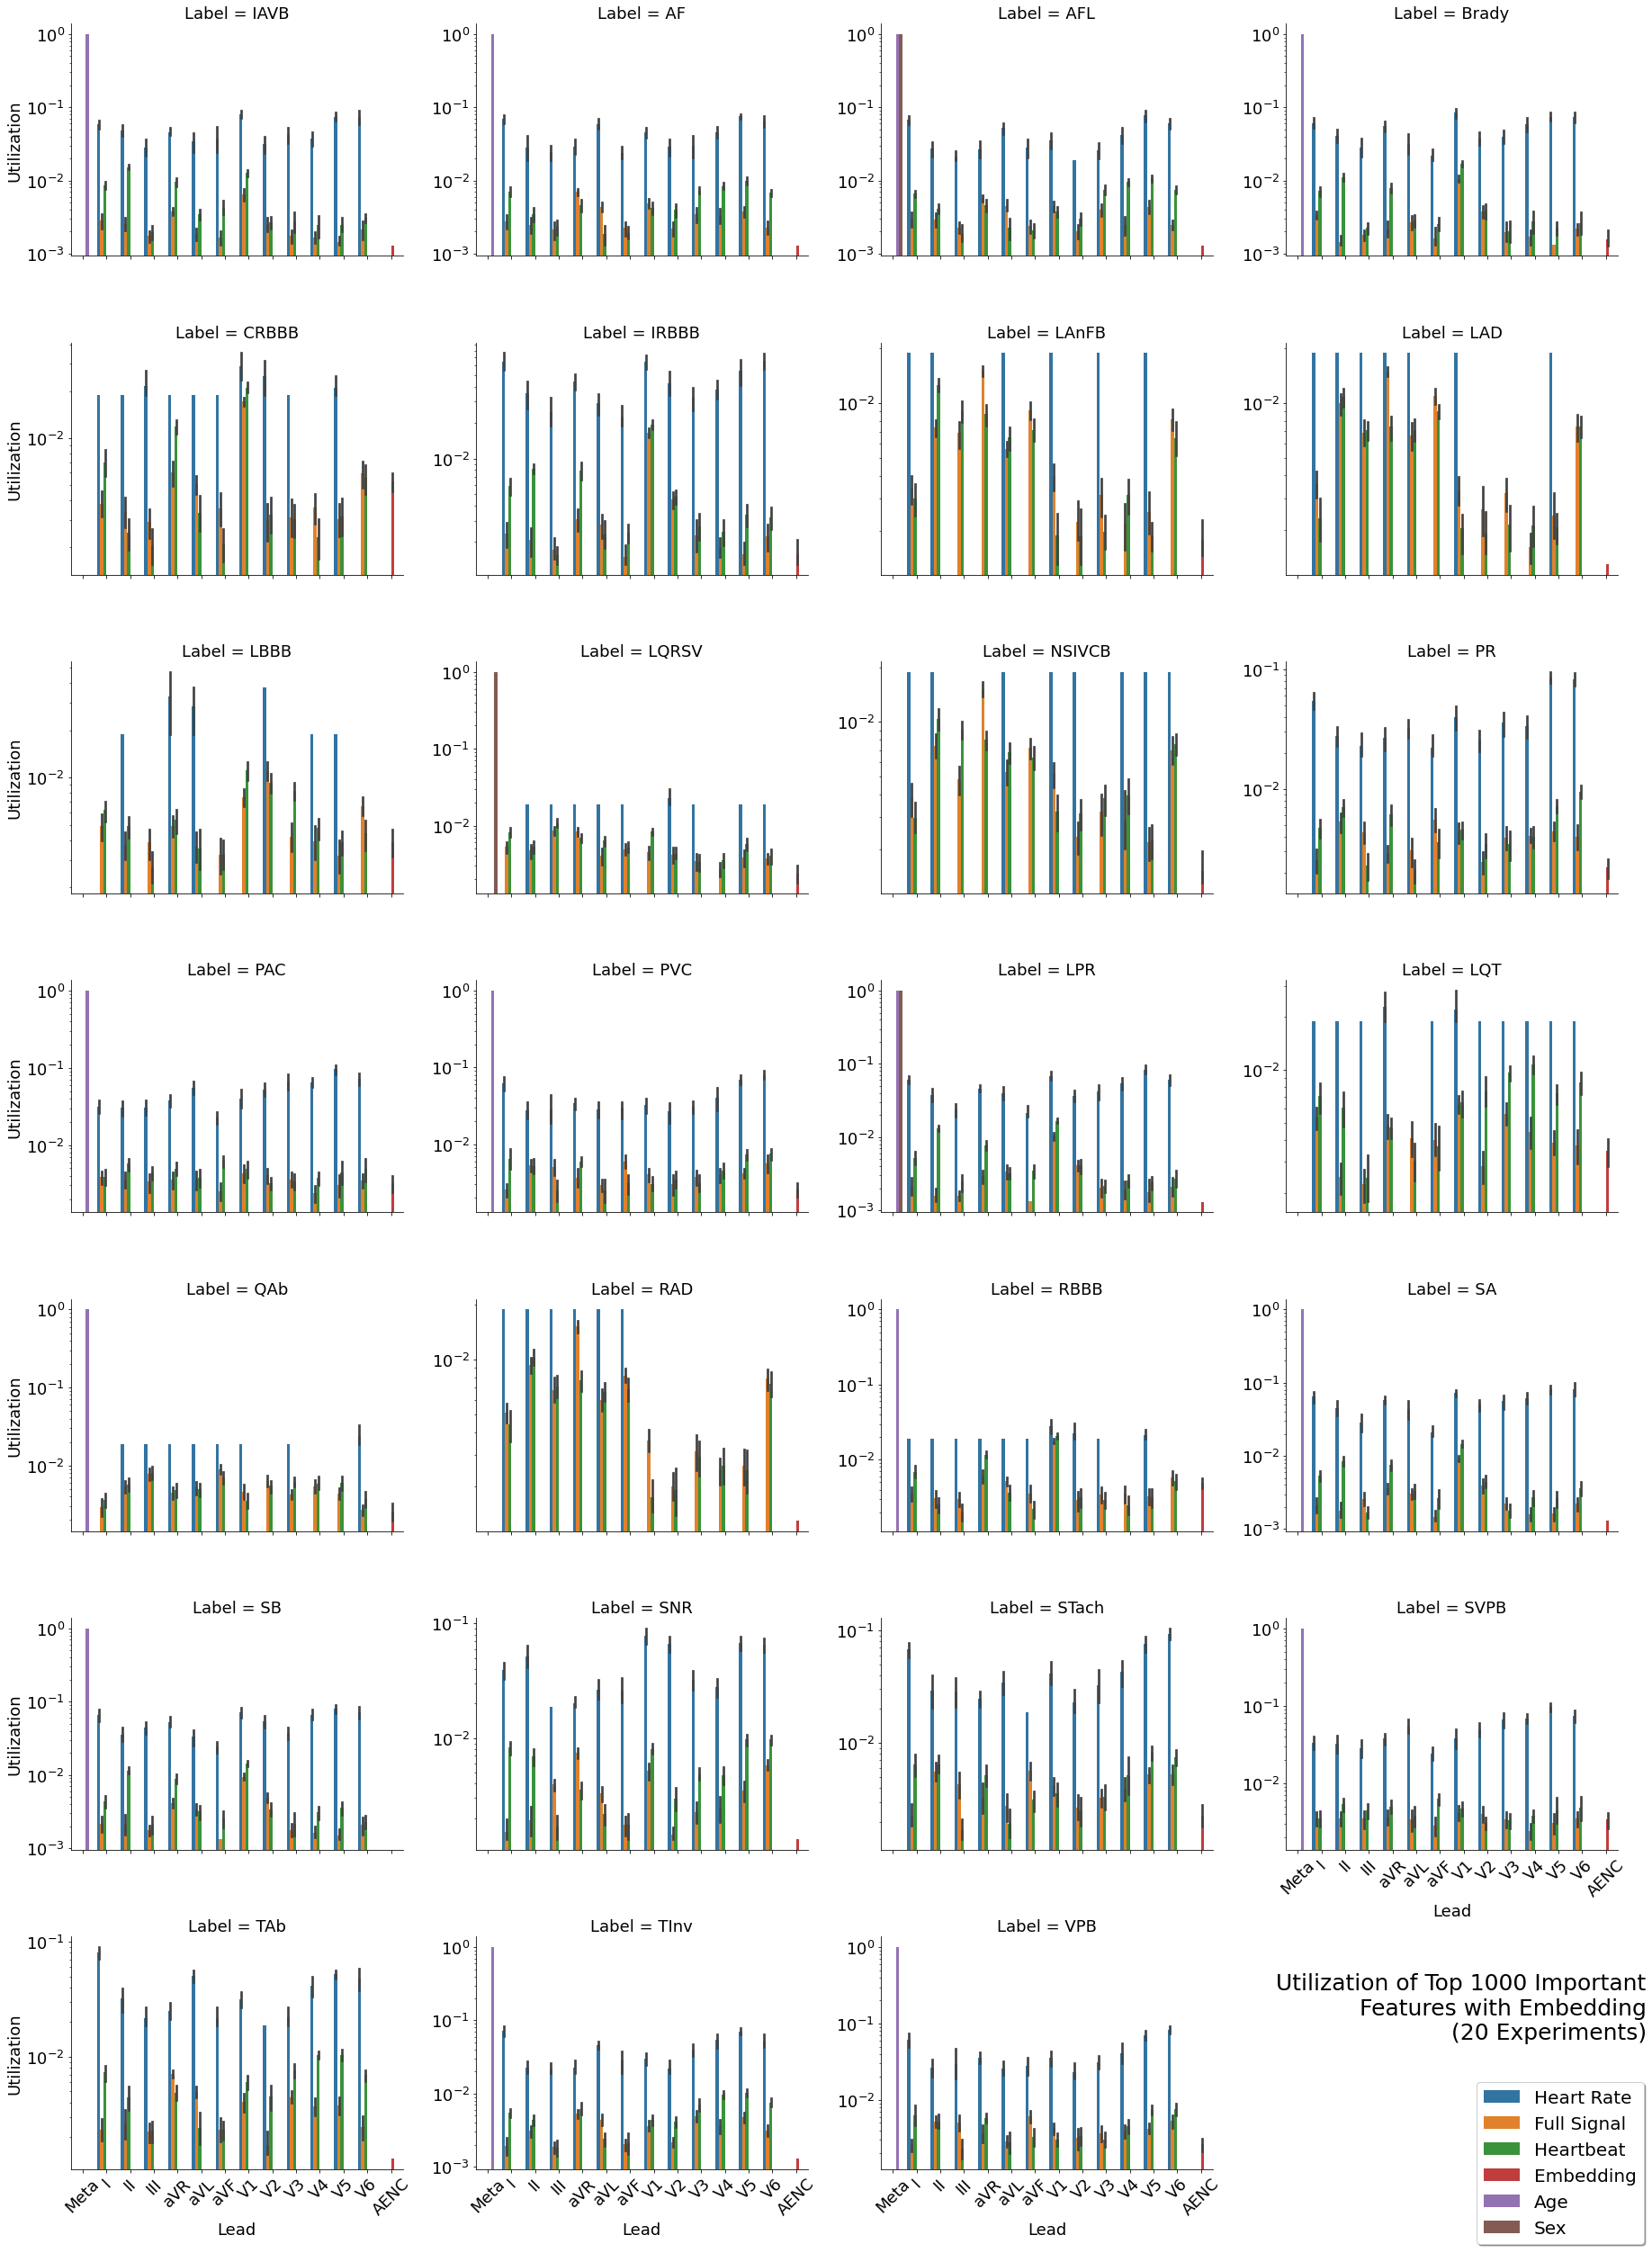

In [25]:
plt.rcParams["font.size"] = "18"
proportional_counter = {}
for row_idx, (label, experiment, lead, feat_type) in imp_feature_df.iterrows():
    proportional_counter[(label, experiment, lead, feat_type)] = proportional_counter.get((label, experiment, lead, feat_type), 0) + 1

proportional_counts = {
    "Label": [],
    "Lead": [],
    "Type": [],
    "Utilization": [],
}

for ((label, experiment, lead, feat_type), count) in proportional_counter.items():
    proportional_counts["Label"].append(label)
    proportional_counts["Lead"].append(lead)
    proportional_counts["Type"].append(feat_type)

    utilization = -1
    if feat_type == "Embedding":
        utilization = count / (768)
    elif feat_type == "Heart Rate":
        utilization = count / (53)
    elif feat_type == "Full Signal" or feat_type == "Heartbeat":
        utilization = count / (763)
    elif feat_type == "Age" or feat_type == "Sex":
        utilization = count
    else:
        raise Exception(feat_type)
    proportional_counts["Utilization"].append(utilization)

prop_counts_df = pd.DataFrame.from_dict(proportional_counts)
display(prop_counts_df)

ax = sns.catplot(
    data=prop_counts_df,
    x="Lead",
    y="Utilization",
    hue="Type",
    col="Label",
    kind="bar",
    hue_order=["Heart Rate", "Full Signal", "Heartbeat", "Embedding", "Age", "Sex"],
    order=["Meta", "I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6", "AENC"],
    sharey=False,
    legend=False,
    legend_out=True,
    aspect=1.15,
    col_wrap=4,
    facet_kws={"subplot_kws": {"yscale": "log"}}
)
ax.set_xticklabels(rotation=45)
ax.add_legend(frameon=True, shadow=True, loc="lower right", prop={"size": 20})
plt.tight_layout()
# ax.axes[0].legend(loc="lower right")
ax.fig.suptitle('Utilization of Top 1000 Important\nFeatures with Embedding\n(20 Experiments)', x=1, y=0.125, ha="right", fontsize=25)
plt.savefig("fig/utilization_top_1000_feature_importances_all_w_embedding.pdf", dpi=300)
plt.show()

In [26]:

# 53 HRV features, 763 Heart Beat, 763 Embedding features per lead 
# All Feats w/ Embd (19718 features)
# 0 age
# 1 sex

with open("feature_cols.json", "r") as f:
    head = json.load(f)
print(f"{len(head)} feature columns")
embd_str = [f"seq_embed_{i}" for i in range(0, 768)]
head += embd_str

head = np.array(head[1:])

# top 1000 distribution
top_100_imp_feats_per_code = {}
for experiment in imp_dict["All Feats w/ Embd"]:
    for code, importances in experiment.items():
        sorted_feat_idxs = importances.argsort()
        imp_idxs = top_100_imp_feats_per_code.get(code, [])
        imp_idxs.append(head[list(sorted_feat_idxs[::-1][:100])])
        top_100_imp_feats_per_code[code] = imp_idxs


imp_feature_dict = {
    "Label": [],      # diagnosis label abbreviation
    "Experiment": [], # experiment number
    "Lead": [], # I, II, III, aVR, aVL, aVF, V1, V2, V3, V4, V5, V6, Other (sex/age)
    "Type": [], # HRV, Heartbeat, Signal, Sex, Age
}

for code, important_features_lists in top_100_imp_feats_per_code.items():
    label = SNOMED_CODE_MAP[code][0]
    for experiment_idx, important_features in enumerate(important_features_lists):
        for important_feature in important_features:
            # determine lead
            try:
                lead = important_feature.split("_")[0]
                if lead == "seq":
                    lead = "AENC"
                elif lead == "age" or lead == "sex":
                    lead = "Meta"
            except:
                lead = "Other"
            
            # determine feature type
            if important_feature.startswith(f"{lead}_HRV") or important_feature.startswith(f"{lead}_ECG_Rate_Mean"):
                feat_type = "Heart Rate"
            elif important_feature.startswith(f"{lead}_hb__"):
                feat_type = "Heartbeat"
            elif important_feature.startswith(f"{lead}_sig__"):
                feat_type = "Full Signal"
            elif important_feature.startswith("seq_embed_"):
                feat_type = "Embedding"
            elif important_feature == "age":
                feat_type = "Age"
            elif important_feature == "sex":
                feat_type = "Sex"
            else:
                raise Exception(important_feature)
            
            imp_feature_dict["Label"].append(label)
            imp_feature_dict["Experiment"].append(experiment_idx)
            imp_feature_dict["Lead"].append(lead)
            imp_feature_dict["Type"].append(feat_type)

imp_feature_df = pd.DataFrame.from_dict(imp_feature_dict)
imp_feature_df.groupby(["Experiment", "Label", "Lead"]).count()

18951 feature columns


Type
Experiment Label Lead      
0          AF    I       13
                 II       3
                 III      4
                 Meta     1
                 V1      10
...                     ...
19         VPB   V5      14
                 V6      14
                 aVF      6
                 aVL      4
                 aVR     11

[6839 rows x 1 columns]

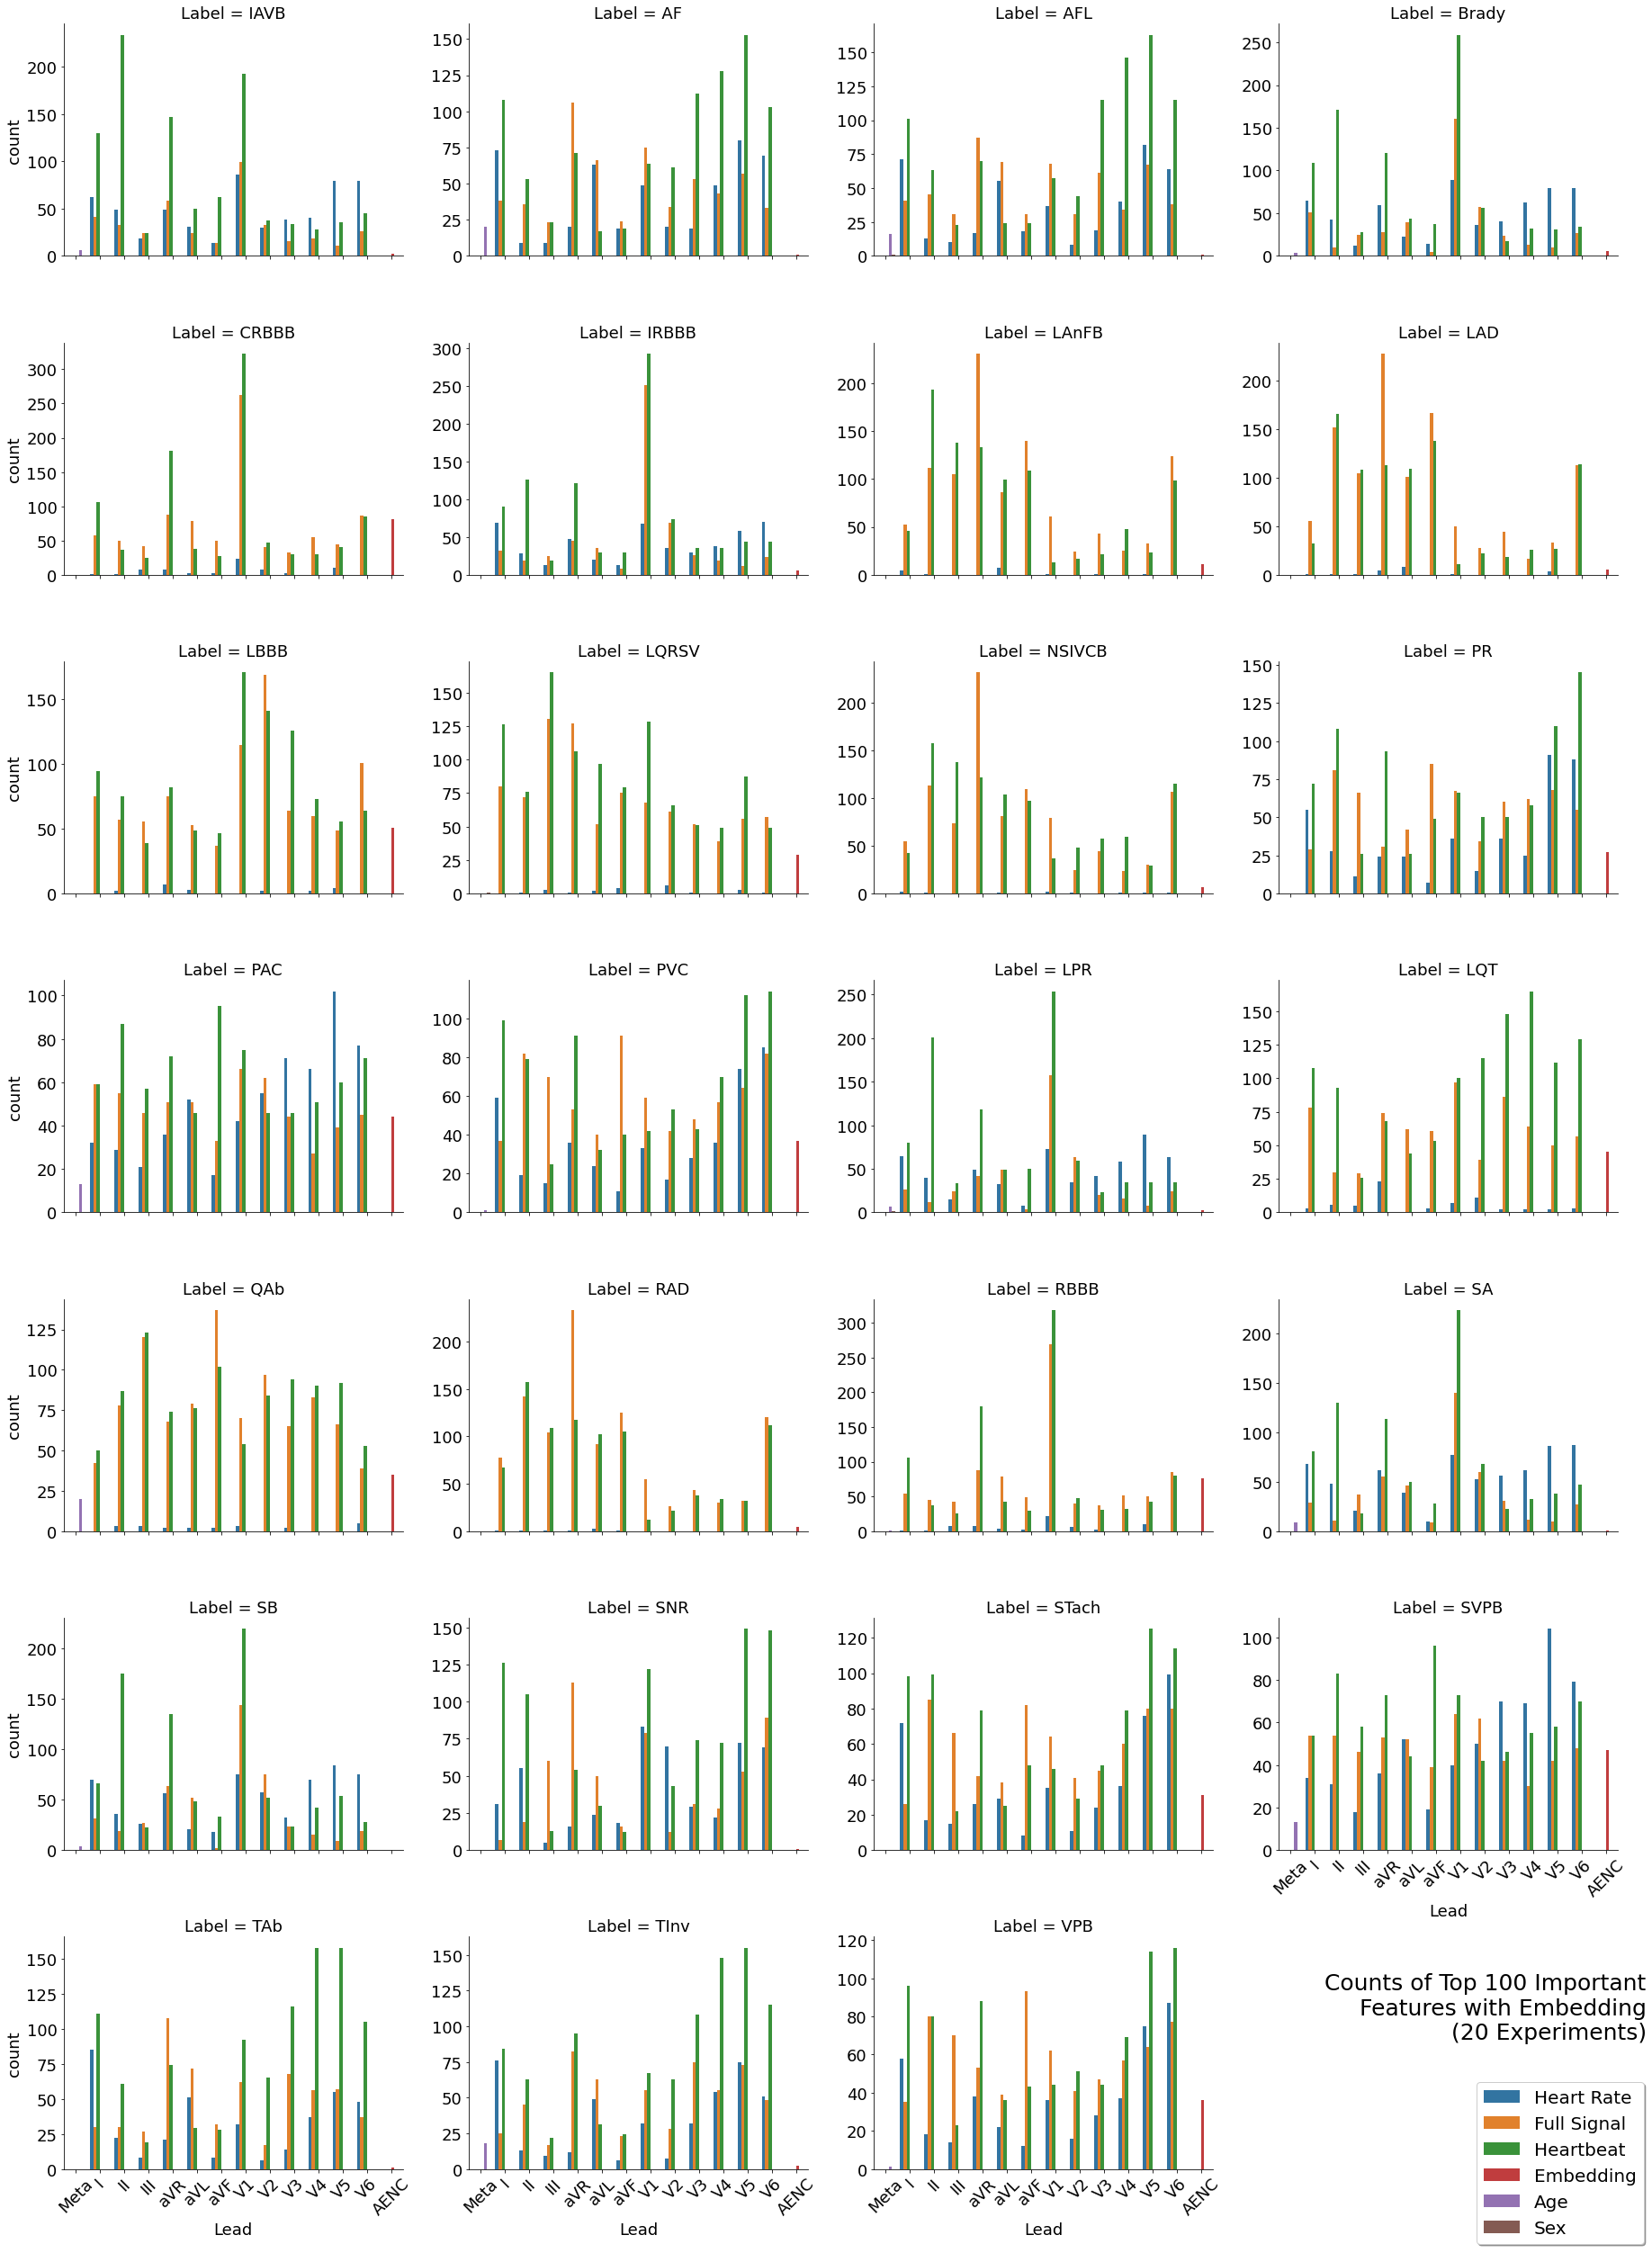

In [29]:
ax = sns.catplot(
    data=imp_feature_df,
    x="Lead",
    hue="Type",
    col="Label",
    kind="count",
    hue_order=["Heart Rate", "Full Signal", "Heartbeat", "Embedding", "Age", "Sex"],
    order=["Meta", "I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6", "AENC"],
    sharey=False,
    legend=False,
    legend_out=True,
    aspect=1.15,
    col_wrap=4
)
ax.set_xticklabels(rotation=45)
ax.add_legend(frameon=True, shadow=True, loc="lower right", prop={"size": 20})
plt.tight_layout()
# ax.axes[0].legend(loc="lower right")
ax.fig.suptitle('Counts of Top 100 Important\nFeatures with Embedding\n(20 Experiments)', x=1, y=0.125, ha="right", fontsize=25)
plt.savefig("fig/top_100_feature_importances_all_w_embedding.pdf", dpi=300)
plt.show()

,Label,Lead,Type,Utilization
0,IAVB,aVR,Heart Rate,0.037736
1,IAVB,I,Full Signal,0.003932
2,IAVB,aVR,Full Signal,0.006553
3,IAVB,V6,Heart Rate,0.056604
4,IAVB,V5,Heart Rate,0.075472
...,...,...,...,...
15804,VPB,aVF,Heart Rate,0.037736
15805,VPB,aVL,Heartbeat,0.001311
15806,VPB,V4,Heartbeat,0.001311
15807,VPB,V1,Heartbeat,0.002621


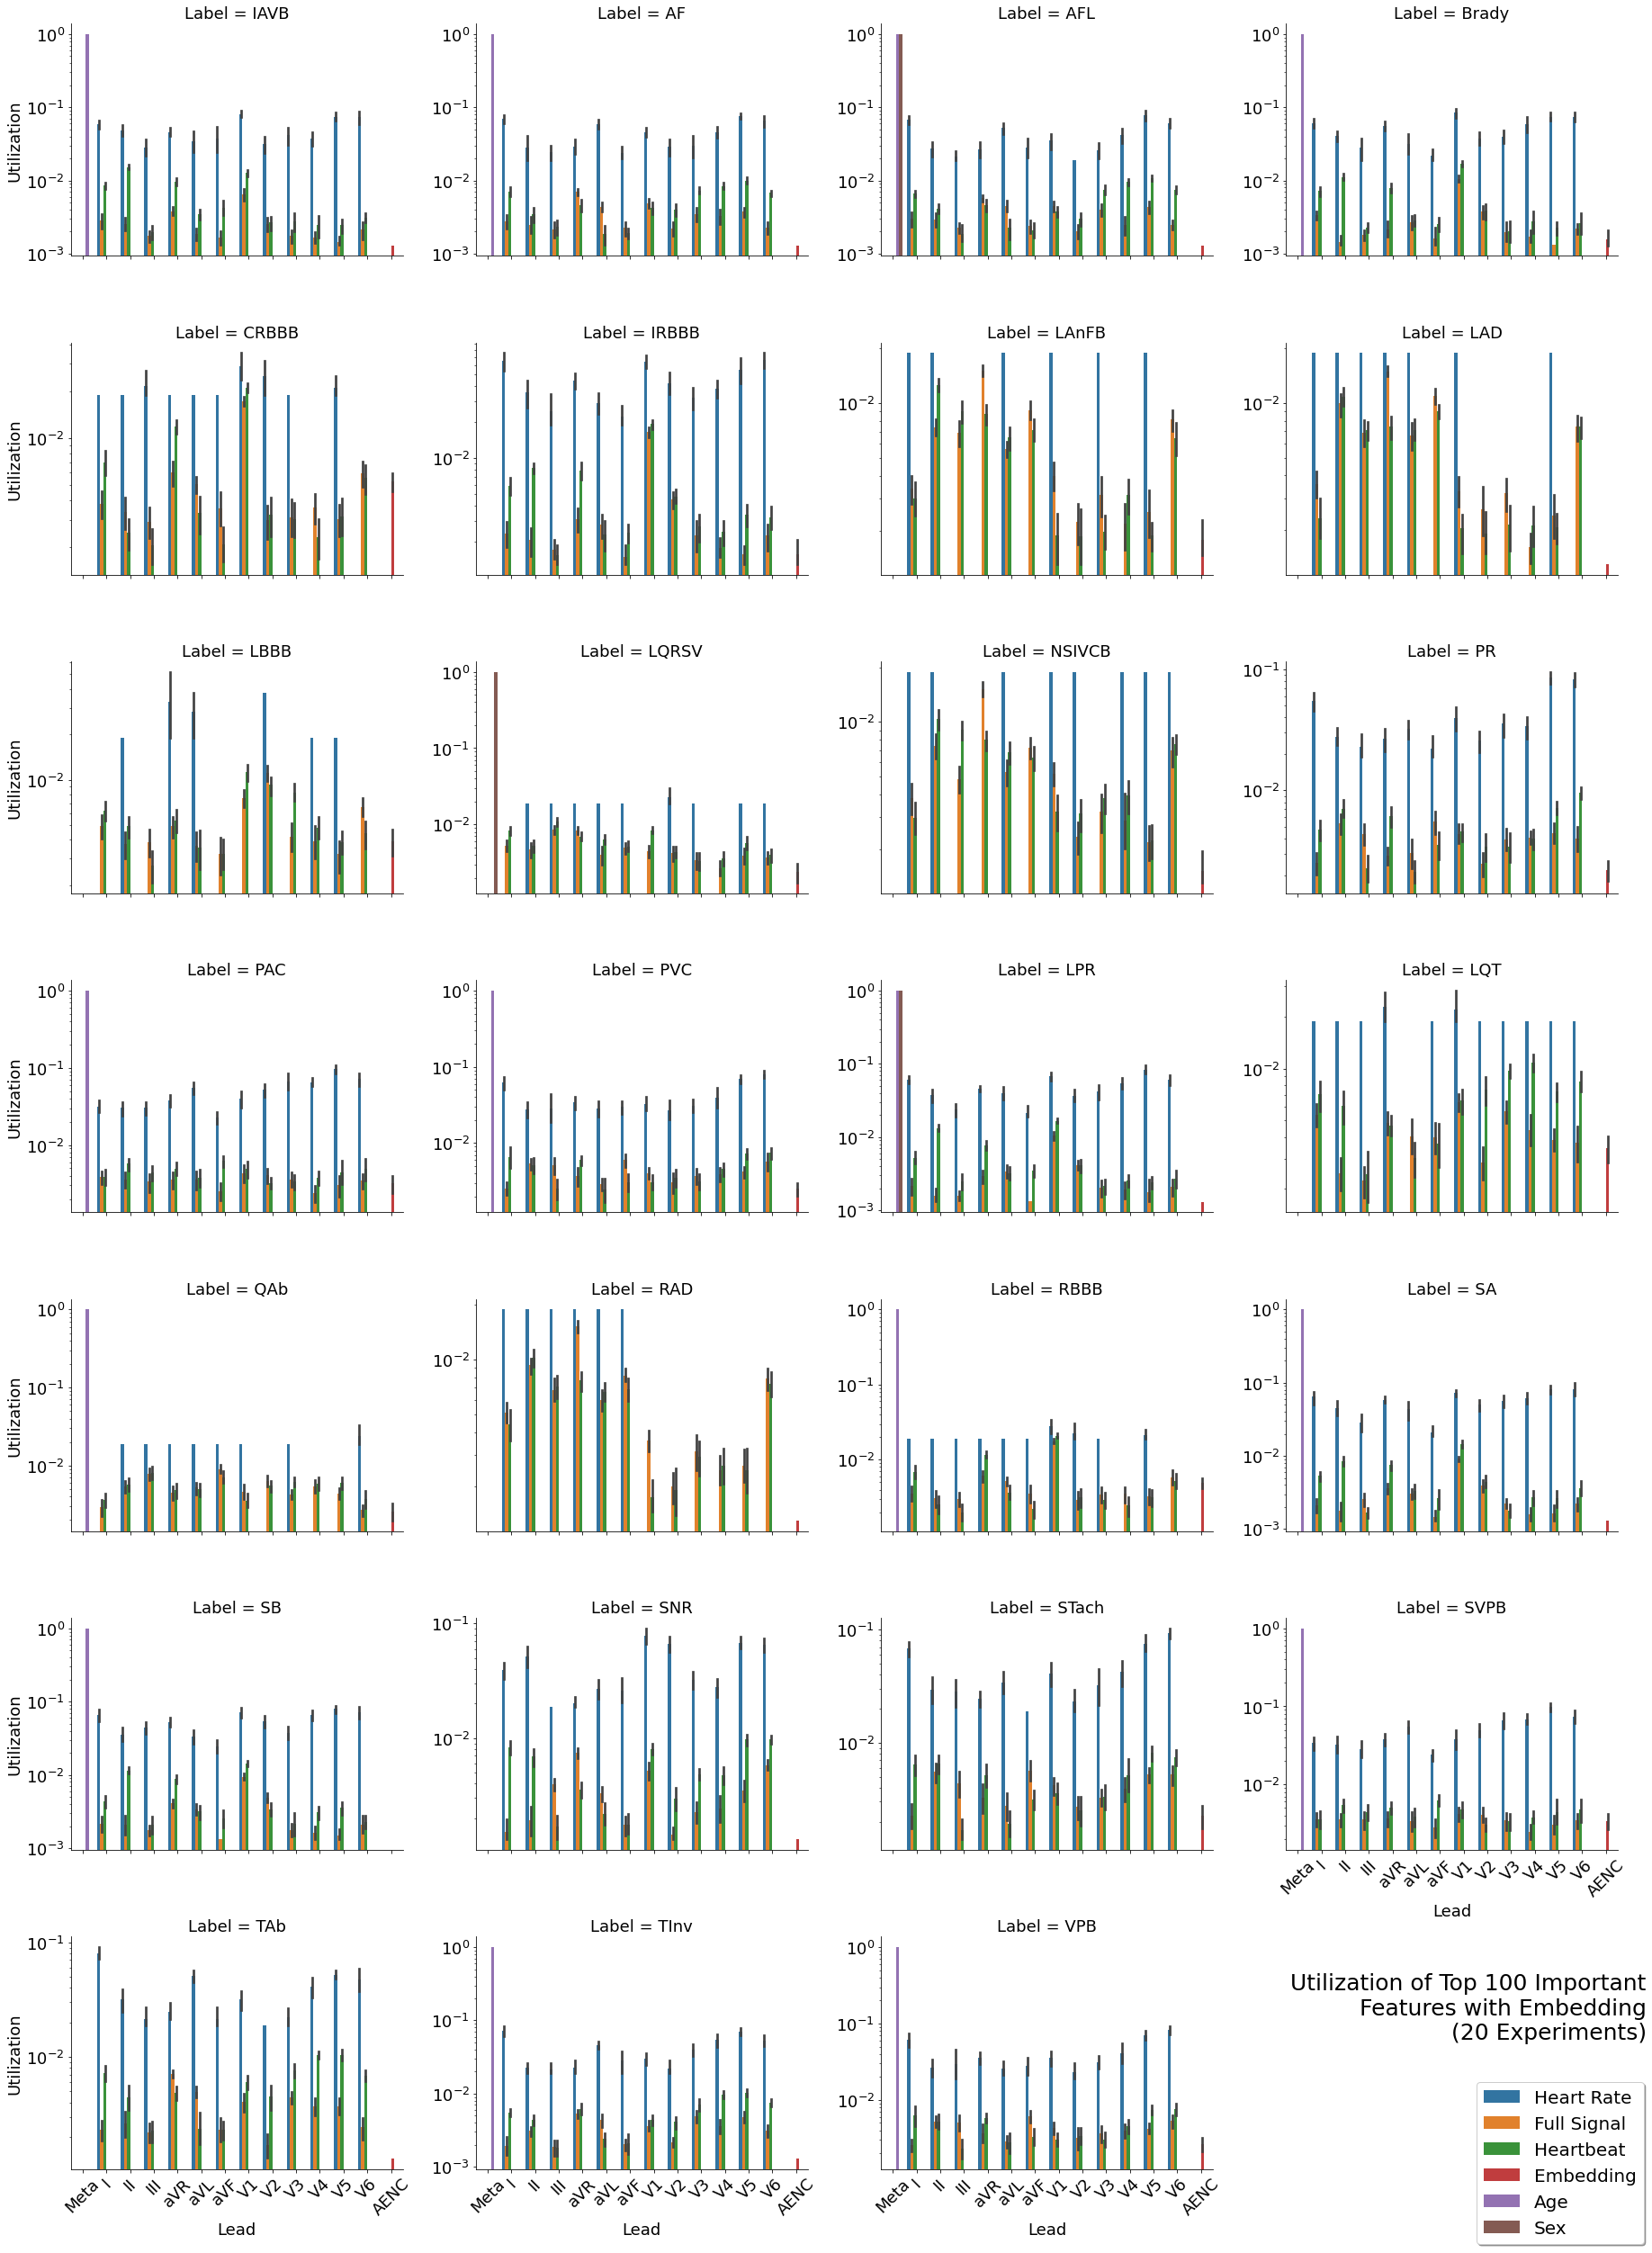

In [30]:
proportional_counter = {}
for row_idx, (label, experiment, lead, feat_type) in imp_feature_df.iterrows():
    proportional_counter[(label, experiment, lead, feat_type)] = proportional_counter.get((label, experiment, lead, feat_type), 0) + 1

proportional_counts = {
    "Label": [],
    "Lead": [],
    "Type": [],
    "Utilization": [],
}

for ((label, experiment, lead, feat_type), count) in proportional_counter.items():
    proportional_counts["Label"].append(label)
    proportional_counts["Lead"].append(lead)
    proportional_counts["Type"].append(feat_type)

    utilization = -1
    if feat_type == "Embedding":
        utilization = count / (768)
    elif feat_type == "Heart Rate":
        utilization = count / (53)
    elif feat_type == "Full Signal" or feat_type == "Heartbeat":
        utilization = count / (763)
    elif feat_type == "Age" or feat_type == "Sex":
        utilization = count
    else:
        raise Exception(feat_type)
    proportional_counts["Utilization"].append(utilization)

prop_counts_df = pd.DataFrame.from_dict(proportional_counts)
display(prop_counts_df)

ax = sns.catplot(
    data=prop_counts_df,
    x="Lead",
    y="Utilization",
    hue="Type",
    col="Label",
    kind="bar",
    hue_order=["Heart Rate", "Full Signal", "Heartbeat", "Embedding", "Age", "Sex"],
    order=["Meta", "I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6", "AENC"],
    sharey=False,
    legend=False,
    legend_out=True,
    aspect=1.15,
    col_wrap=4,
    facet_kws={"subplot_kws": {"yscale": "log"}}
)

ax.add_legend(frameon=True, shadow=True, loc="lower right", prop={"size": 20})
ax.set_xticklabels(rotation=45)
plt.tight_layout()
# ax.axes[0].legend(loc="lower right")
ax.fig.suptitle('Utilization of Top 100 Important\nFeatures with Embedding\n(20 Experiments)', x=1, y=0.125, ha="right", fontsize=25)
plt.savefig("fig/utilization_top_100_feature_importances_all_w_embedding.pdf", dpi=300)
plt.show()

In [17]:
all_feats = np.array(list(imp_dict["All Feats"][0].values())).mean(axis=0)

with open("feature_cols.json", "r") as f:
    head = json.load(f)
print(f"{len(head)} feature columns")
embd_str = [f"seq_embed_{i}" for i in range(0, 768)]
head += embd_str
head = np.array(head[1:])

all_feats_w_embd = np.array(list(imp_dict["All Feats w/ Embd"][0].values())).mean(axis=0)
# top 1000 distribution
sorted_feat_idxs = all_feats_w_embd.argsort()
head[list(sorted_feat_idxs[::-1][:1000])]

avgd_exp_features = {
    "All Feats w/ Embd"
}

for important_feature in important_features:
    # determine lead
    try:
        lead = important_feature.split("_")[0]
        if lead == "seq":
            lead = "AENC"
        elif lead == "age" or lead == "sex":
            lead = "Meta"
    except:
        lead = "Other"

    # determine feature type
    if important_feature.startswith(f"{lead}_HRV") or important_feature.startswith(f"{lead}_ECG_Rate_Mean"):
        feat_type = "Heart Rate"
    elif important_feature.startswith(f"{lead}_hb__"):
        feat_type = "Heartbeat"
    elif important_feature.startswith(f"{lead}_sig__"):
        feat_type = "Full Signal"
    elif important_feature.startswith("seq_embed_"):
        feat_type = "Embedding"
    else:
        feat_type = "Age/Sex"

    imp_feature_dict["Label"].append(label)
    imp_feature_dict["Experiment"].append(experiment_idx)
    imp_feature_dict["Lead"].append(lead)
    imp_feature_dict["Type"].append(feat_type)


18951 feature columns


# Labelwise F1 Scores

In [31]:
# determine experiment paths

# engineered features + autoencoder embeddings
full_feat_embd = glob("cinc-2020-redux-embedding/*test_class_labelwise.csv")
print(f"len(full_feat_embd) == {len(full_feat_embd)}")
top_1000_feat_embd = glob("cinc-2020-redux-embedding/top_1000/*test_class_labelwise.csv")
print(f"len(top_1000_feat_embd) == {len(top_1000_feat_embd)}")
top_100_feat_embd = glob("cinc-2020-redux-embedding/top_100/*test_class_labelwise.csv")
print(f"len(top_100_feat_embd) == {len(top_100_feat_embd)}")
avgd_top_1000_feat_embd = glob("cinc-2020-redux-embedding/averaged_top_1000/*test_class_labelwise.csv")
print(f"len(avgd_top_1000_feat_embd) == {len(avgd_top_1000_feat_embd)}")
avgd_top_100_feat_embd = glob("cinc-2020-redux-embedding/averaged_top_100/*test_class_labelwise.csv")
print(f"len(avgd_top_100_feat_embd) == {len(avgd_top_100_feat_embd)}")

# engineered features only
full_man_feat = glob("full_output/*test_class_labelwise.csv")
print(f"len(full_man_feat) == {len(full_man_feat)}")
top_1000_man_feat = glob("full_output/top_1000/*test_class_labelwise.csv")
print(f"len(top_1000_man_feat) == {len(top_1000_man_feat)}")
top_100_man_feat = glob("full_output/top_100/*test_class_labelwise.csv")
print(f"len(top_100_man_feat) == {len(top_100_man_feat)}")
avgd_top_1000_man_feat = glob("full_output/averaged_top_1000/*test_class_labelwise.csv")
print(f"len(avgd_top_1000_feat_embd) == {len(avgd_top_1000_man_feat)}")
avgd_top_100_man_feat = glob("full_output/averaged_top_100/*test_class_labelwise.csv")
print(f"len(avgd_top_100_feat_embd) == {len(avgd_top_100_man_feat)}")

experiment_results = {
    "All Feats\nw/ Embd": full_feat_embd,
    "All Feats": full_man_feat,
    "Avg Top 1000\nFeats w/ Embd": avgd_top_1000_feat_embd,
    "Top 1000 Feats\nw/ Embd": top_1000_feat_embd,
    "Avg Top 100\nFeats w/ Embd": avgd_top_100_feat_embd,
    "Top 100 Feats\nw/ Embd": top_100_feat_embd,
    "Avg Top 1000 Feats": avgd_top_1000_man_feat,
    "Top 1000 Feats": top_1000_man_feat,
    "Avg Top 100 Feats": avgd_top_100_man_feat,
    "Top 100 Feats": top_100_man_feat,
}


len(full_feat_embd) == 20
len(top_1000_feat_embd) == 20
len(top_100_feat_embd) == 20
len(avgd_top_1000_feat_embd) == 20
len(avgd_top_100_feat_embd) == 20
len(full_man_feat) == 20
len(top_1000_man_feat) == 20
len(top_100_man_feat) == 20
len(avgd_top_1000_feat_embd) == 20
len(avgd_top_100_feat_embd) == 20


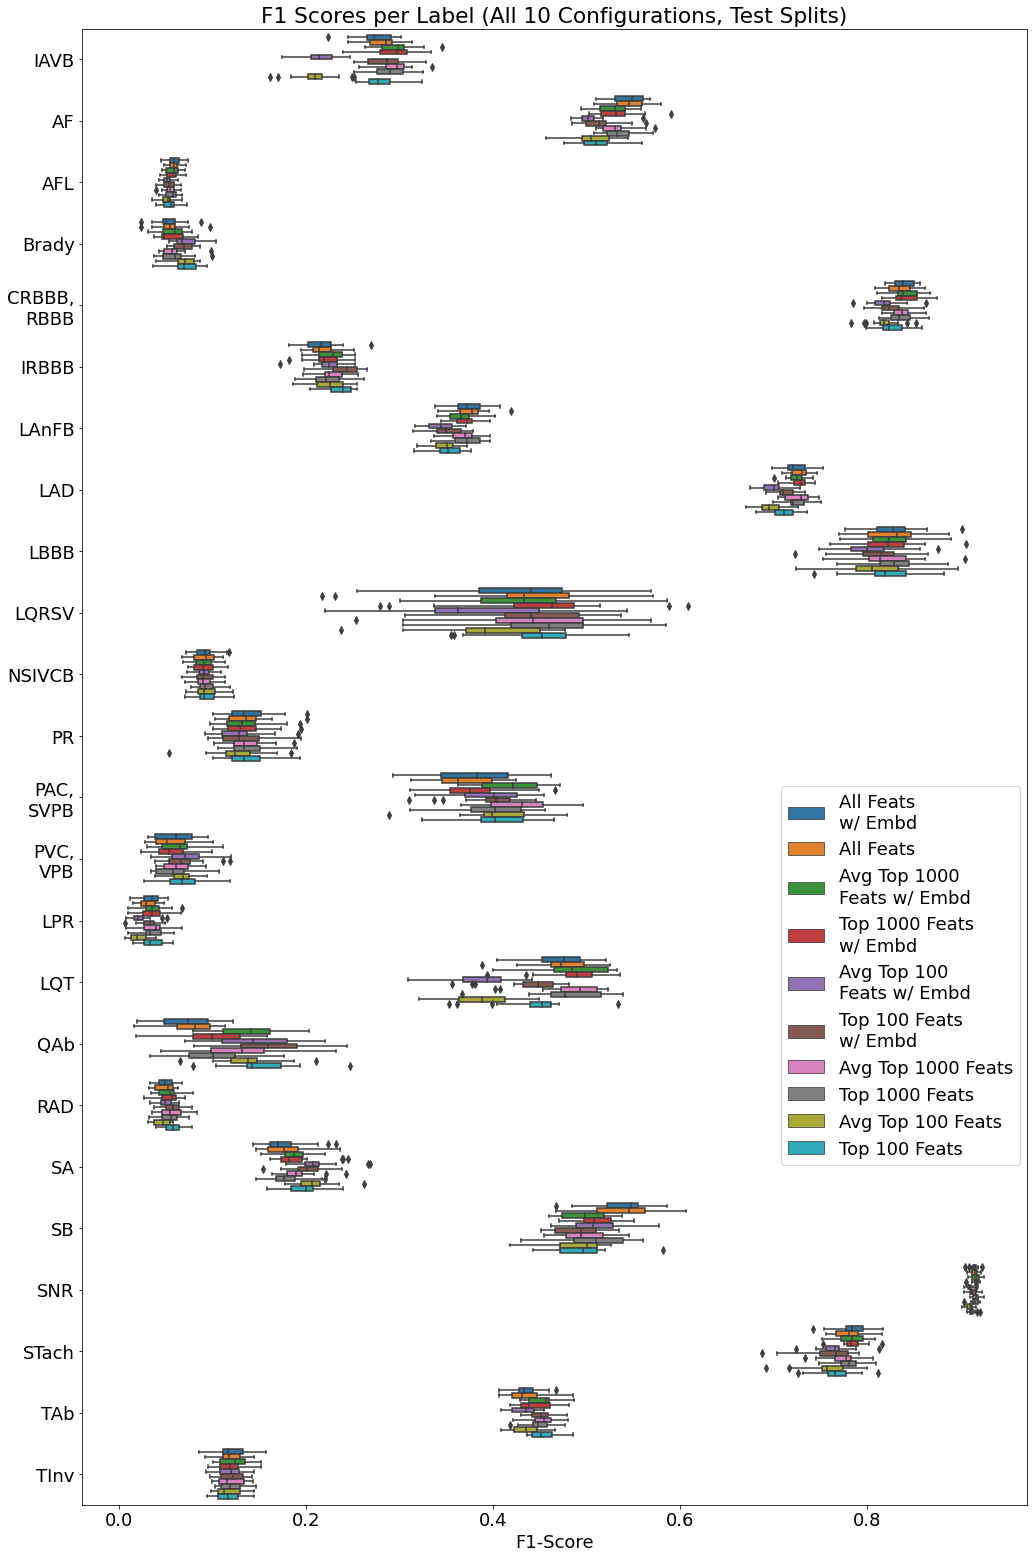

In [51]:
f_measures = {
    "Experiment": [],
    "Label": [],
    "F1-Score": []
}
for experiment_name, filepaths in experiment_results.items():
    for filepath in filepaths:
        with open(filepath, "r") as f:
            for k, v in pd.read_csv(f).to_dict(orient="index")[2].items():
                if k == "Classes":
                    continue
                f_measures["Experiment"].append(experiment_name)
                f_measures["Label"].append(SNOMED_CODE_MAP[k][0])
                f_measures["F1-Score"].append(v)
# print(f_measures)
f1_box_plot_data = pd.DataFrame(f_measures)
f1_box_plot_data
plt.figure(figsize=(15, 22))
ax = sns.boxplot(
    data=f1_box_plot_data,
    x="F1-Score",
    y="Label",
    hue="Experiment",
)

plt.legend(loc=(0.74, 0.23))

ax.set_title("F1 Scores per Label (All 10 Configurations, Test Splits)")
# handle duplicates:
y_tick_labels = ax.get_yticklabels()
for y_tick_label in y_tick_labels:
    y_text = y_tick_label.get_text()
    if y_text == "CRBBB":
        y_tick_label.set_text("CRBBB,\nRBBB")
    elif y_text == "PAC":
        y_tick_label.set_text("PAC,\nSVPB")
    elif y_text == "PVC":
        y_tick_label.set_text("PVC,\nVPB")
ax.set_yticklabels(y_tick_labels, rotation=0)
ax.set_ylabel("")
plt.tight_layout()

plt.savefig("fig/label_f1s_10_configuration.pdf", bbox_inches="tight", dpi=300)

plt.show()